In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import functions as fn

## Plot of the Surface

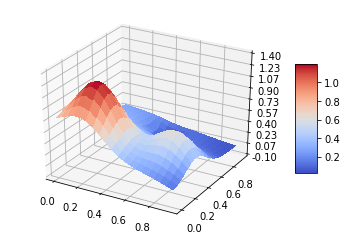

In [150]:
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)
z = fn.FrankeFunction(x, y, 0)


fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Part a) Ordinary Least Squares on the data set

### Perform a OLS regression using polynomials in x and y up to fifth order. 
### Find the confidence interval nof the estimators $\beta$
### Use the MSE- and R2 score functions.  
### Scalind of the data, split of the data. 

In [ ]:
# Initializing the data
N = 70
x, y = np.random.uniform(0,1,size=(2,N))
x_,y_ = np.meshgrid(x,y)
z = fn.FrankeFunction(x_, y_, 0.3)
z = np.ravel(z)

# Creating the design matrix
n=5 
X = fn.create_X(x_, y_, n)
        
# Splitting into testing and training
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Inverting XTX matrix with SVD to avoid singular matrix
XTXinv = fn.SVDinv(X_train.T.dot(X_train))


# Estimating the Ordinary Least Squares Beta Matrix
OLSbeta = XTXinv.dot(X_train.T).dot(z_train)

# Making the prediciton
z_tilde = X_train @ OLSbeta
z_predict = X_test @ OLSbeta

print("The MSE for the prediciton is:")
print(fn.MSE(z_test, z_predict), "\n")

print("The R2 for the prediciton is:")
print(fn.R2(z_test, z_predict), "\n")

## Beta coefficents and their 95% confidence intervals

In [140]:
# Calculating the variance
betavariance = np.sqrt(np.diagonal(XTXinv)*np.var(z_train-z_tilde))

# Plotting the figure

fig, ax = plt.subplots(figsize=(15,6))

labels= ['1','$x$','$y$','$x^2$','$xy$','$y^2$','$x^3$','$x^2y$','$xy^2$','$y^3$','$x^4$',
         '$x^3y$','$x^2y^2$','$xy^3$','$y^4$','$x^5$','$x^4y$','$x^3y^2$','$x^2y^3$','$xy^4$','$y^5$']

x_pos = np.arange(len(labels))
ax.bar(x_pos, OLSbeta, yerr=2*betavariance, alpha=0.5,capsize=10)
ax.set_ylabel('Beta coeffient', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=14)
ax.set_title('Beta coefficient with confidence intervals of 95%', fontsize=20)

plt.show()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


ValueError: shape mismatch: objects cannot be broadcast to a single shape

## Visual Help:
### Plotting function on $[0,1]\times[0,1]$ using the Beta coefficients

In [ ]:
def PredictPlot(OLSbeta, N,n, title='Prectided FrankeFunction', savefig=False):
    # Plotting 
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    x_,y_ = np.meshgrid(x,y)

    X = fn.create_X(x_,y_,n)
    Z = X @ OLSbeta
    Z=Z.reshape(N,N)
    if savefig == True:
        plt.savefig(title+".png")    
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    surf = ax.plot_surface(x_, y_, Z, cmap=cm.coolwarm,
                            linewidth=0, antialiased=False)

    plt.title(title)
    
    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

In [ ]:
PredictPlot(OLSbeta,100,5)

# Part b): Bias-variance trade-off and resampling techniques.

### Make a figure similar to Fig. 2.11 of Hasties, et al., with only the testing and training MSEs.
### Show that the cost function
### $C(\mathbf{X}, \mathbf{\beta}) = \frac{1}{n}\sum_{i=0}^{n-1}(y_i -\tilde{y_i})^2 = \mathbb{E}[(\mathbf{y}-\mathbf{\tilde{y}})^2] $
### can be rewritten as 
### $\mathbb{E}[(\mathbf{y}-\mathbf{\tilde{y}})^2] = \frac{1}{n}\sum_{i} (f_i -\mathbb{E}[\mathbf{\tilde{y}}])^2 +  \frac{1}{n}\sum_{i}(y_i -\mathbb{E}[\mathbf{\tilde{y}}])^2 + \sigma^2$

### Explain the terms, which one is bias and variance and their interpretations

### Perform bias variance tradeoff with increasing polynomials (model complexity) and number of data points, and bootstrap resampling methods on the training and testing data

In [30]:
N = 30
x, y = np.random.uniform(0,1,size=(2,N))
x_,y_ = np.meshgrid(x,y)

z = fn.FrankeFunction(x_, y_,0.5)
z = np.ravel(z)

# Array of polynomial degrees
n=np.arange(30)
X = fn.create_X(x_,y_,n[-1])

print(X.shape, z.shape)


# Splitting into testing and training
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Creating arrays for train and test error
TrainError = np.zeros(n.shape)
TestError = np.zeros(n.shape)

# Scaling the train and test set
X_train, X_test = fn.Scaling(X_train, X_test)

z_tilde = 0
z_predict = 0


# Calculating the expected test and training error with increasing complexity
iterations = 200
for i in range(len(n)):
    for iter in range(iterations):
        # How many columns of the design matrix allowed.
        q = int((i+1)*(i+2)/2)
        X_trainD = X_train[:,:q]
        X_testD = X_test[:,:q]


        # Inverting XTX matrix with SVD to avoid singular matrix
        XTXinv = fn.SVDinv(X_trainD.T.dot(X_trainD))

        # Estimating the Ordinary Least Squares Beta Matrix
        OLSbeta = XTXinv.dot(X_trainD.T).dot(z_train)

        # Making the prediciton
        z_tilde += X_trainD @ OLSbeta
        z_predict += X_testD @ OLSbeta
    
    z_tilde = z_tilde/iterations
    z_predict = z_predict/iterations
    
    TrainError[i] = fn.MSE(z_train, z_tilde)
    TestError[i] = fn.MSE(z_test, z_predict)



(900, 465) (900,)


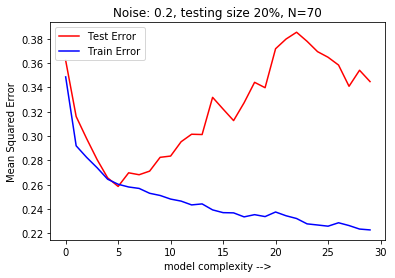

In [31]:
startpoint = 0
endpoint = 30
plt.plot(n[startpoint:endpoint],TestError[startpoint:endpoint],'r' ,label='Test Error')
plt.plot(n[startpoint:endpoint],TrainError[startpoint:endpoint],'b' ,label='Train Error')
plt.xlabel('model complexity -->')
plt.ylabel('Mean Squared Error')
plt.title("Noise: 0.5, testing size 20%, N=30")

plt.legend()
plt.show()

## Perform bias variance tradeoff with increasing polynomials (model complexity) and number of data points, and bootstrap resampling methods on the training and testing data

### Incorporating bootstrap techniques

In [47]:
# Initalizing
N = 30
n = np.arange(30)

# Initalizing the dataset
x, y = np.random.uniform(0,1,size=(2,N))
x_,y_ = np.meshgrid(x,y)

z = fn.FrankeFunction(x_, y_,0.5)
z = np.ravel(z)

# Creating design matrix for the maximum polynomial degree. 
X = fn.create_X(x_,y_,n[-1])

# Test Train splitting of data
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Scaling the train and test set
X_train, X_test = fn.Scaling(X_train, X_test)

# Intializing error bias and variance
error = np.zeros(n.shape)
bias = np.zeros(n.shape)
variance = np.zeros(n.shape)

# Bootstrap parameters
n_bootstraps = 100

for i in range(len(n)):
    # How many columns of the design matrix allowed.
    q = int((i+1)*(i+2)/2)
    X_trainD = X_train[:,:q]
    X_testD = X_test[:,:q]

    # Setting up the array for the bootstrapped predictions
    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    
    for j in range(n_bootstraps):
        x_, z_  = fn.Shuffle_Data(X_trainD, z_train)
        OLSbeta = fn.SVDinv(x_.T.dot(x_)).dot(x_.T).dot(z_) 
        z_pred[:,j] = X_testD @ OLSbeta 

    #Reshaping
    z_test = z_test.reshape(len(z_test),1)
    
    
    error[i] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    bias[i]  = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[i] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

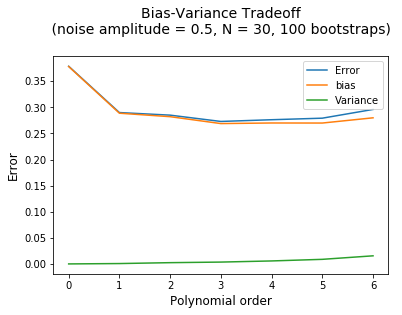

In [48]:
startpoint = 0
endpoint = 7


plt.plot(n[startpoint:endpoint], error[startpoint:endpoint], label='Error')
plt.plot(n[startpoint:endpoint], bias[startpoint:endpoint], label='bias')
plt.plot(n[startpoint:endpoint], variance[startpoint:endpoint], label='Variance')
plt.legend()
plt.ylabel("Error", fontsize=12)
plt.xlabel("Polynomial order",  fontsize=12)
plt.title("Bias-Variance Tradeoff\n (noise amplitude = 0.5, N = 30, 100 bootstraps) \n", fontsize =14)
plt.savefig("biasvariance.png", dpi=100)

plt.show()


## Cross-Validation as resampling techniques, adding more complexity.

In [42]:
# Initalizing
N = 30
n=np.arange(30)

# Initalizing the dataset
x, y = np.random.uniform(0,1,size=(2,N))
x_,y_ = np.meshgrid(x,y)

z = fn.FrankeFunction(x_, y_,0.5)
z = np.ravel(z)

# Creating design matrix for the maximum polynomial degree. 
X = fn.create_X(x_,y_,n[-1])

# Splitting into testing and training data
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Scaling the train and test set
X_train, X_test = fn.Scaling(X_train, X_test)

# Intializing error bias and variance
error = np.zeros(n.shape)
bias = np.zeros(n.shape)
variance = np.zeros(n.shape)

# CV fold parameters 
folds = 10
foldsize = np.int(len(X_train)/folds)

for i in range(len(n)):
    # How many columns of the design matrix allowed.
    q = int((i+1)*(i+2)/2)
    X_trainD = X_train[:,:q]
    X_testD = X_test[:,:q]

    # Setting up the array for the CV-fold predictions
    z_pred = np.empty((z_test.shape[0], folds))
    
    for j in range(folds):

        # Reshuffling the data
        # x_, z_ = Shuffle_Data(X_trainD, z_train)
        x_ = X_trainD
        z_ = z_train
        
        x_ = x_[(foldsize*j):(foldsize*(j+1)),:]
        z_ = z_[(foldsize*j):(foldsize*(j+1))]
        
        # Computing the beta matrix on the fold
        OLSbeta = fn.SVDinv(x_.T.dot(x_)).dot(x_.T).dot(z_) 
        z_pred[:,j] = X_testD @ OLSbeta 

    #Reshaping
    z_test = z_test.reshape(len(z_test),1)
    
    error[i] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    bias[i]  = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[i] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

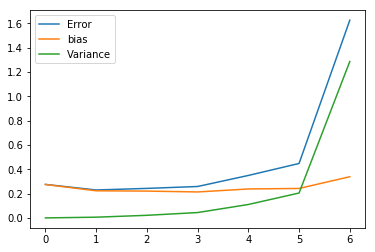

In [45]:
startpoint = 0
endpoint = 7

plt.plot(n[startpoint:endpoint], error[startpoint:endpoint], label='Error')
plt.plot(n[startpoint:endpoint], bias[startpoint:endpoint], label='bias')
plt.plot(n[startpoint:endpoint], variance[startpoint:endpoint], label='Variance')
plt.legend()
plt.show()

## Ridge Regression on the Franke funcion with resampling

### Perform Ridge Regression with either matrix inversion or SVD.
### Use bootstrap for the same polynomial range as in b), and cross-valdiation as in c), but plotted for different values of $\lambda$

### Bootstrapping:

In [50]:
# Initalizing
N = 30
n = np.arange(30)

# Initalizing the dataset
x, y = np.random.uniform(0,1,size=(2,N))
x_,y_ = np.meshgrid(x,y)

z = fn.FrankeFunction(x_, y_,0.5)
z = np.ravel(z)

# Creating design matrix for the maximum polynomial degree. 
X = fn.create_X(x_,y_,n[-1])

# Test Train splitting of data
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Scaling the train and test set
X_train, X_test = fn.Scaling(X_train, X_test)

# Lambda
lamb = 10**np.linspace(-5,1,7)

# Bootstrap parameters
n_bootstraps = 50


# Intializing error bias and variance
error = np.zeros((len(lamb),len(n)))
bias = np.zeros((len(lamb),len(n)))
variance = np.zeros((len(lamb),len(n)))



for k in range(len(lamb)):
        for i in range(len(n)):
            # How many columns of the design matrix allowed.
            q = int((i+1)*(i+2)/2)
            X_trainD = X_train[:,:q]
            X_testD = X_test[:,:q]

            # Setting up the array for the bootstrapped predictions
            z_pred = np.empty((z_test.shape[0], n_bootstraps))

            for j in range(n_bootstraps):
                x_, z_  = fn.Shuffle_Data(X_trainD, z_train)
                RIDGEbeta = fn.SVDinv(x_.T.dot(x_)+lamb[k]*np.eye(q)).dot(x_.T).dot(z_) 
                z_pred[:,j] = X_testD @ RIDGEbeta 

            #Reshaping
            z_test = z_test.reshape(len(z_test),1)


            error[k,i] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
            bias[k,i]  = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
            variance[k,i] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

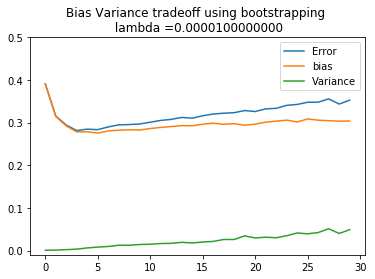

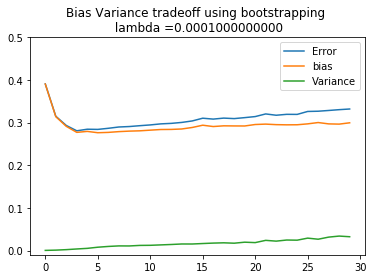

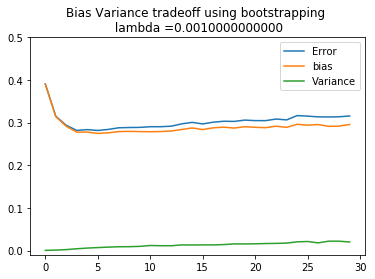

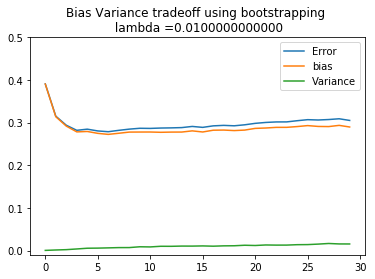

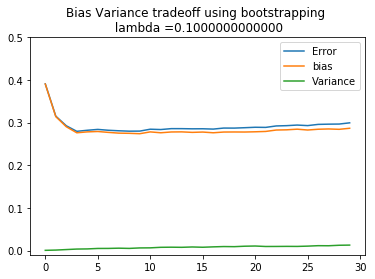

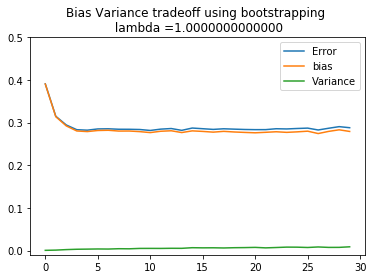

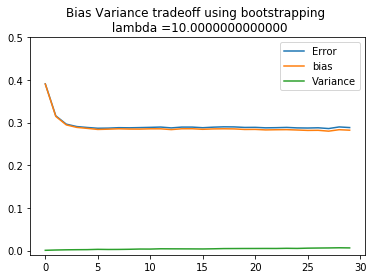

In [52]:
startpoint = 0
endpoint = 30

for k in range(len(lamb)):
    plt.plot(n[startpoint:endpoint], error[k,startpoint:endpoint], label='Error')
    plt.plot(n[startpoint:endpoint], bias[k,startpoint:endpoint], label='bias')
    plt.plot(n[startpoint:endpoint], variance[k,startpoint:endpoint], label='Variance')
    plt.title("Bias Variance tradeoff using bootstrapping \n lambda =%.13f" % lamb[k])
    plt.legend()
    plt.ylim(-0.01, 0.5)
    plt.show()

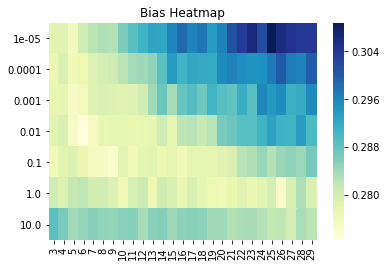

In [91]:
import seaborn as sns

lambtick = np.ndarray.tolist(lamb)
ntick = np.ndarray.tolist(n)

## Bias Heatmap
ax = sns.heatmap(bias[:,3:], cmap="YlGnBu", yticklabels = lambtick, xticklabels = ntick[3:])
plt.title("Bias Heatmap, Ridge Regressions with bootstrapping n = 50")
plt.show()

## Variance Heatmap
ax = sns.heatmap(variance[:,3:], cmap="YlGnBu", yticklabels = lambtick, xticklabels = ntick[3:])
plt.title("Variance Heatmap, Ridge Regressions with bootstrapping n = 50")
plt.show()

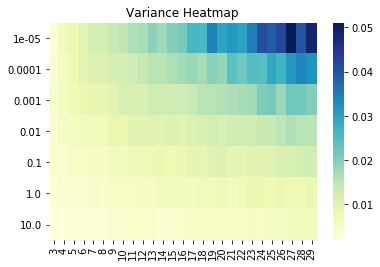

## Beta Coefficients with respect to a fixed penalty term

(1,) (1,)


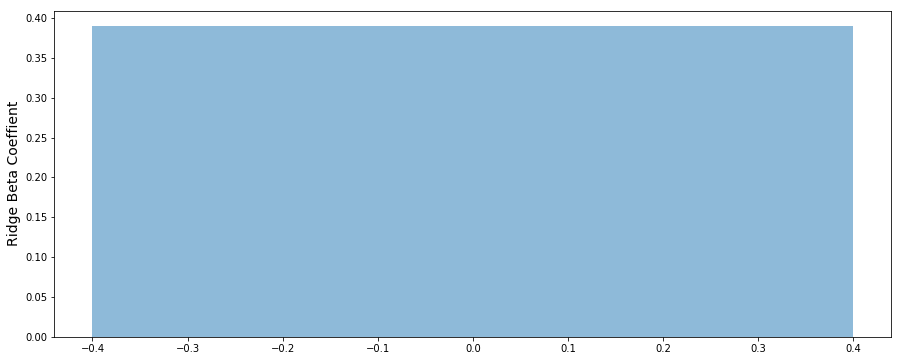

(3,) (3,)


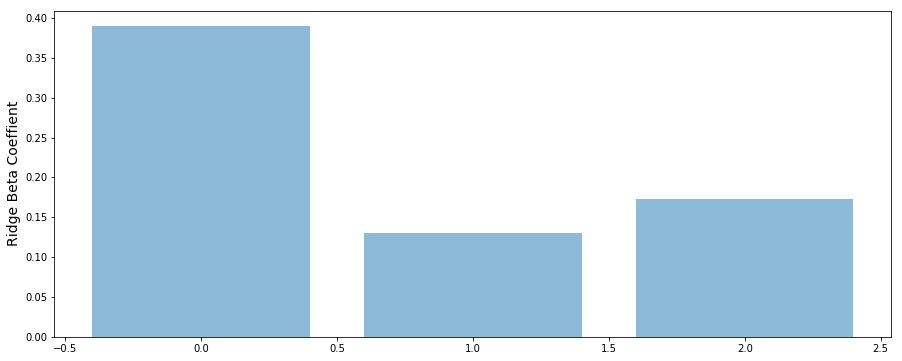

(6,) (6,)


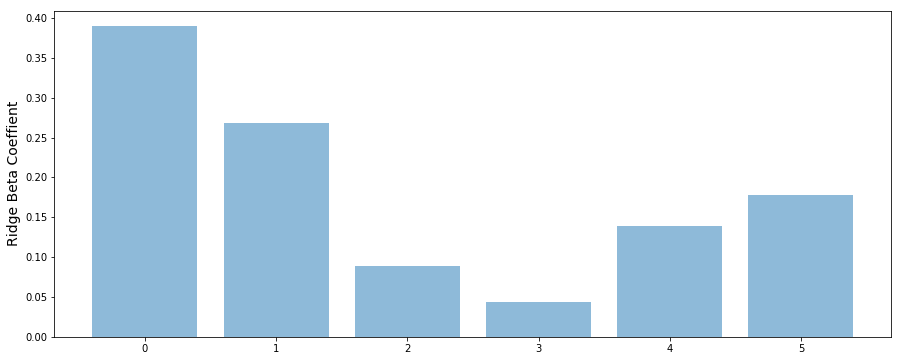

(10,) (10,)


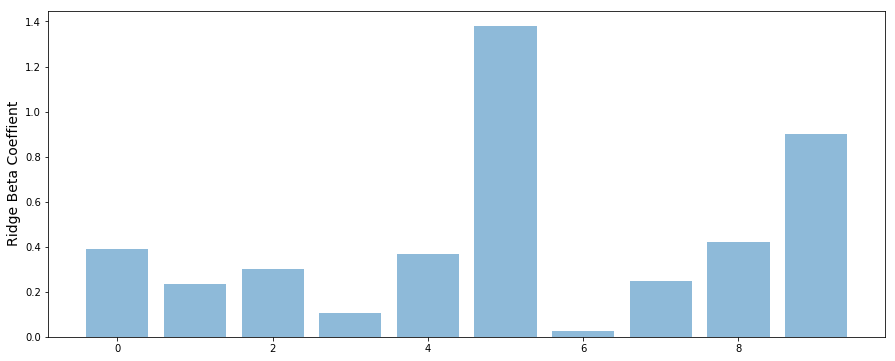

(15,) (15,)


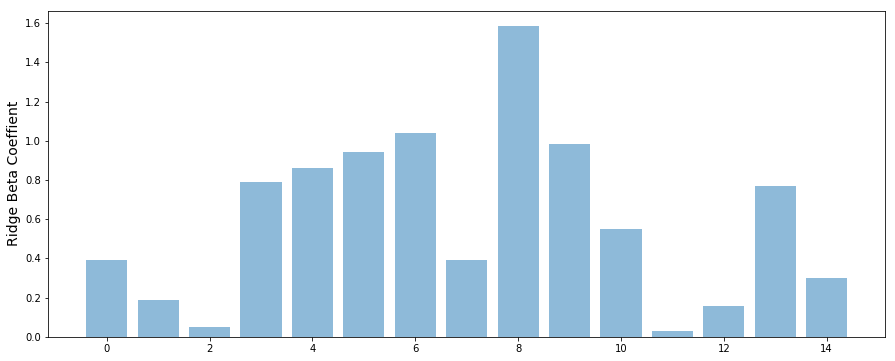

(21,) (21,)


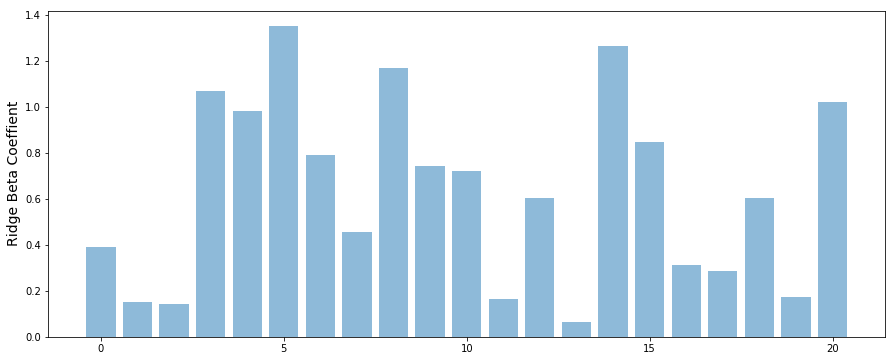

(28,) (28,)


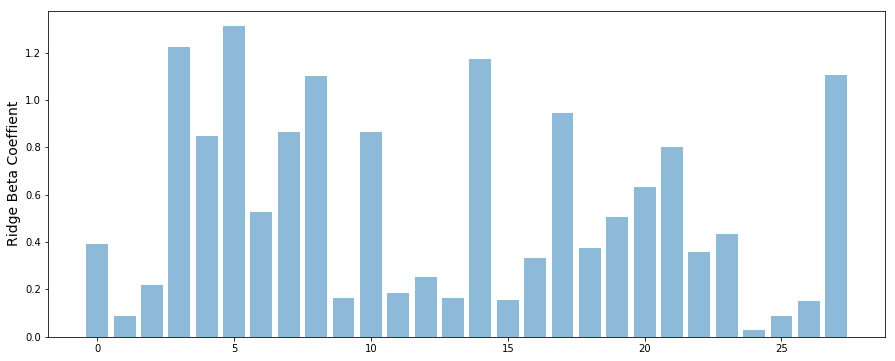

(36,) (36,)


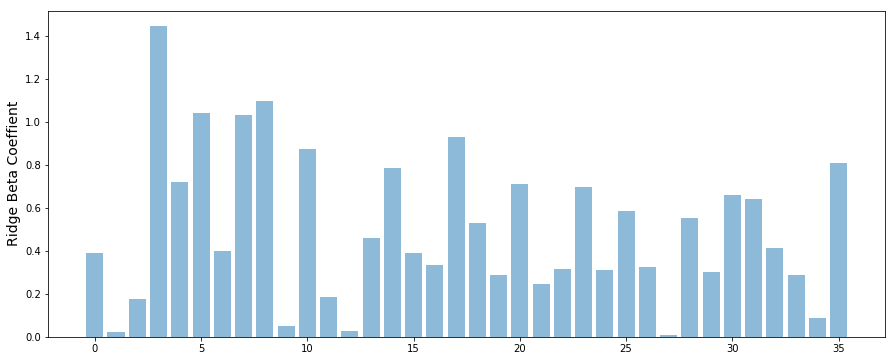

(45,) (45,)


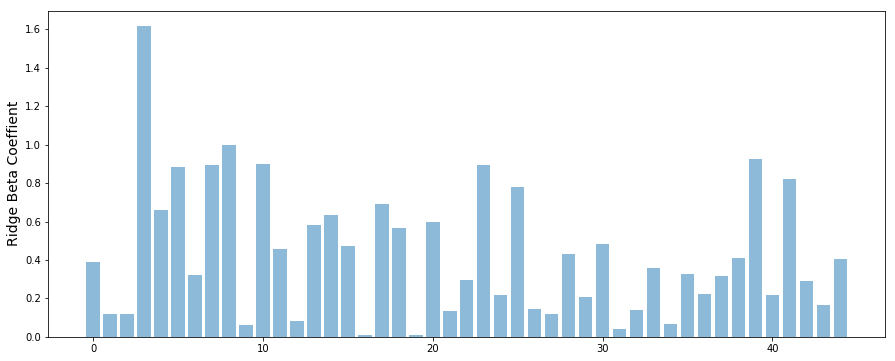

(55,) (55,)


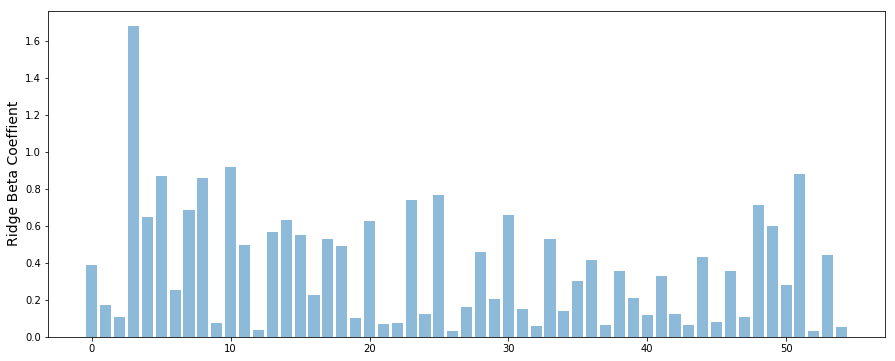

(66,) (66,)


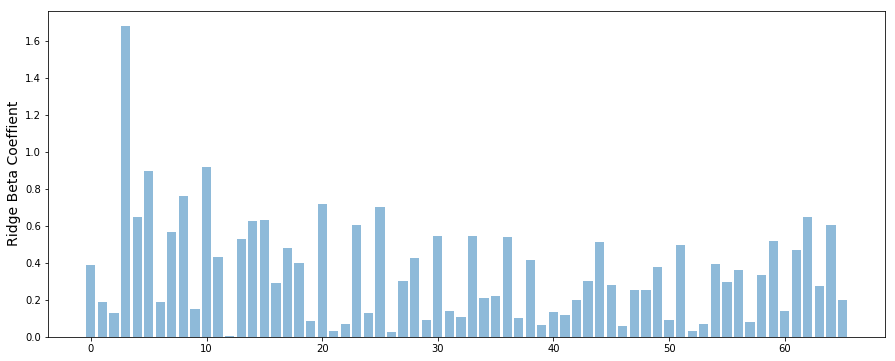

(78,) (78,)


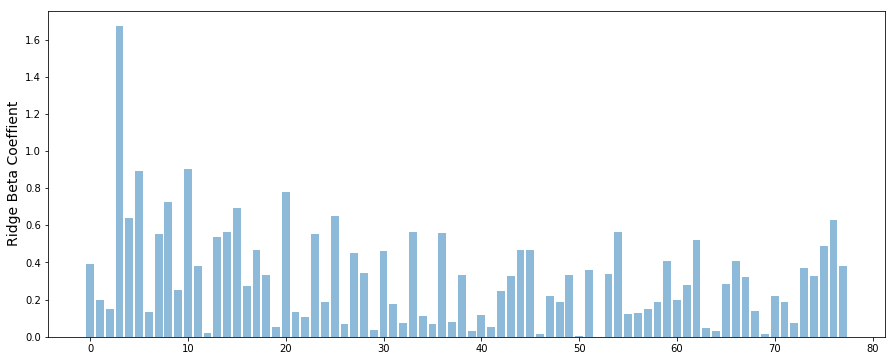

(91,) (91,)


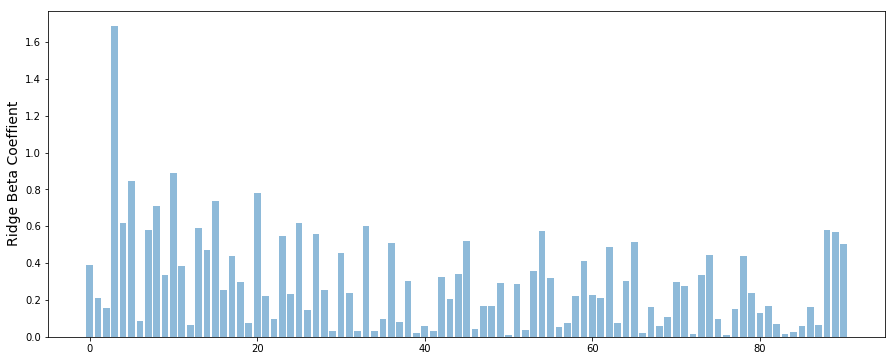

(105,) (105,)


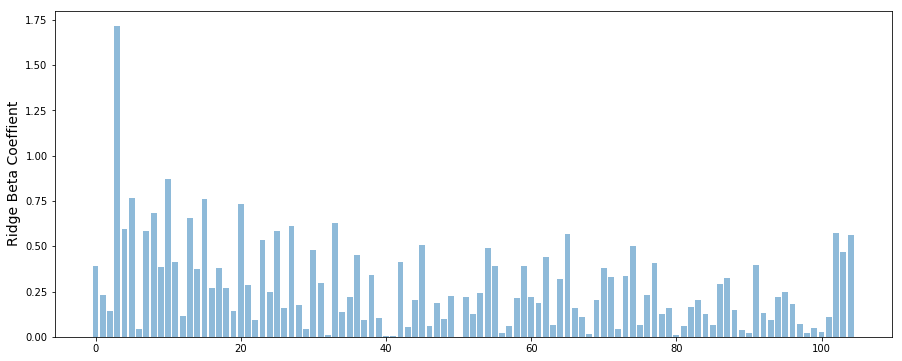

In [145]:
N = 30
x, y = np.random.uniform(0,1,size=(2,N))
x_,y_ = np.meshgrid(x,y)
z = fn.FrankeFunction(x_, y_,0.5)
z = np.ravel(z)

# Array of polynomial degrees
n=np.arange(15)[1:]
X = fn.create_X(x_,y_,n[-1])

# Splitting into testing and training
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Creating arrays for train and test error
TrainError = np.zeros(n.shape)
TestError = np.zeros(n.shape)

# Scaling the train and test set
X_train, X_test = fn.Scaling(X_train, X_test)

for i in range(len(n)):

    # How many columns of the design matrix allowed.
    q = int((i+1)*(i+2)/2)
    X_trainD = X_train[:,:q]
    X_testD = X_test[:,:q]


    RIDGEbeta = fn.SVDinv(X_trainD.T.dot(X_trainD)+0.1*np.eye(q)).dot(X_trainD.T).dot(z_train) 
    z_tilde = X_trainD @ RIDGEbeta
    z_predict = X_testD @ RIDGEbeta
   

    
    fig, ax = plt.subplots(figsize=(15,6))

    x_pos = np.arange((len(RIDGEbeta)))
    print(x_pos.shape, RIDGEbeta.shape)
    plt.figure()
    ax.bar(x_pos, np.abs(RIDGEbeta), alpha=0.5,capsize=10)
    ax.set_ylabel('Ridge Beta Coeffient', fontsize=14)
    plt.show()
    
    TrainError[i] = fn.MSE(z_train, z_tilde)
    TestError[i] = fn.MSE(z_test, z_predict)



## e) Lasso Regression on the Franke function with resampling

### Perform Lasso Regression with Scikit-Learn.
### Use bootstrap for the same polynomial range as in b), and cross-valdiation as in c), but plotted for different values of $\lambda$
### Give a critical discussion of the three methods and a judgement of which model fits the data best.

In [107]:
from sklearn import linear_model

# Initalizing
N = 30
n = np.arange(30)

# Initalizing the dataset
x, y = np.random.uniform(0,1,size=(2,N))
x_,y_ = np.meshgrid(x,y)

z = fn.FrankeFunction(x_, y_,0.5)
z = np.ravel(z)

# Creating design matrix for the maximum polynomial degree. 
X = fn.create_X(x_,y_,n[-1])

# Test Train splitting of data
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Scaling the train and test set
X_train, X_test = fn.Scaling(X_train, X_test)

# Lambda
lamb = 10**np.linspace(-7,0,8)

# Bootstrap parameters
n_bootstraps = 50


# Intializing error bias and variance
error = np.zeros((len(lamb),len(n)))
bias = np.zeros((len(lamb),len(n)))
variance = np.zeros((len(lamb),len(n)))



for k in range(len(lamb)):
        for i in range(len(n)):
            # How many columns of the design matrix allowed.
            q = int((i+1)*(i+2)/2)
            X_trainD = X_train[:,:q]
            X_testD = X_test[:,:q]

            # Setting up the array for the bootstrapped predictions
            z_pred = np.empty((z_test.shape[0], n_bootstraps))

            for j in range(n_bootstraps):
                x_, z_  = fn.Shuffle_Data(X_trainD, z_train)
                clf = linear_model.Lasso(alpha=lamb[k], fit_intercept=True, tol=0.1, max_iter=1000)
                clf.fit(x_, z_)
                LASSObeta = clf.coef_
                z_pred[:,j] = X_testD @ LASSObeta 

            #Reshaping
            z_test = z_test.reshape(len(z_test),1)


            error[k,i] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
            bias[k,i]  = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
            variance[k,i] = np.mean( np.var(z_pred, axis=1, keepdims=True) )



C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


(1,) (1,)


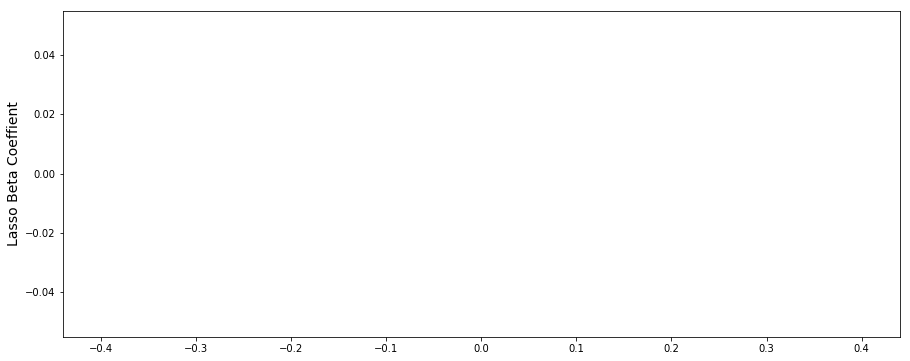

(3,) (3,)


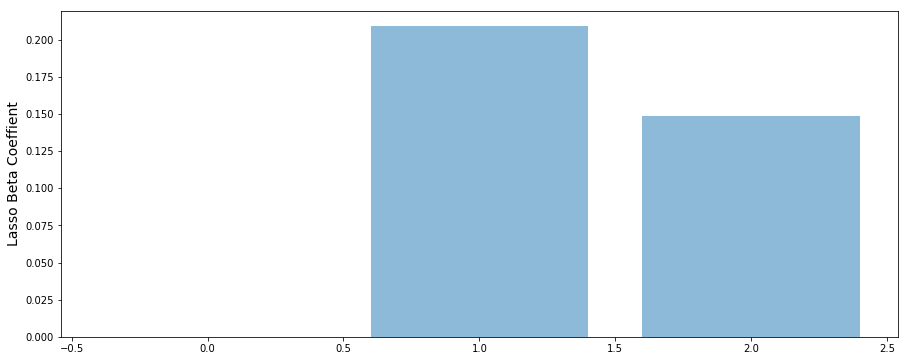

(6,) (6,)


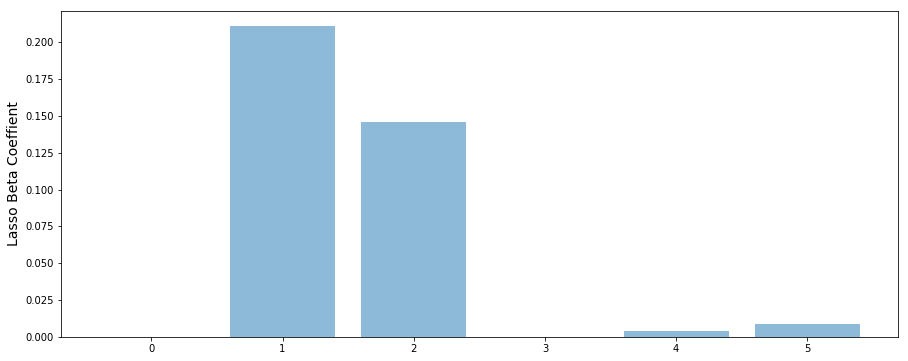

(10,) (10,)


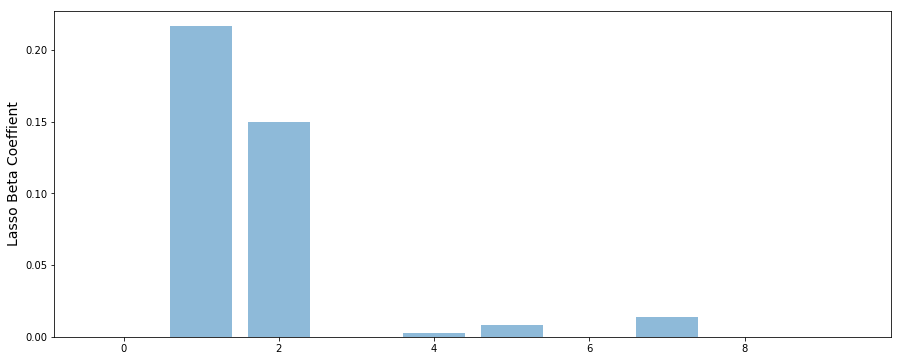

(15,) (15,)


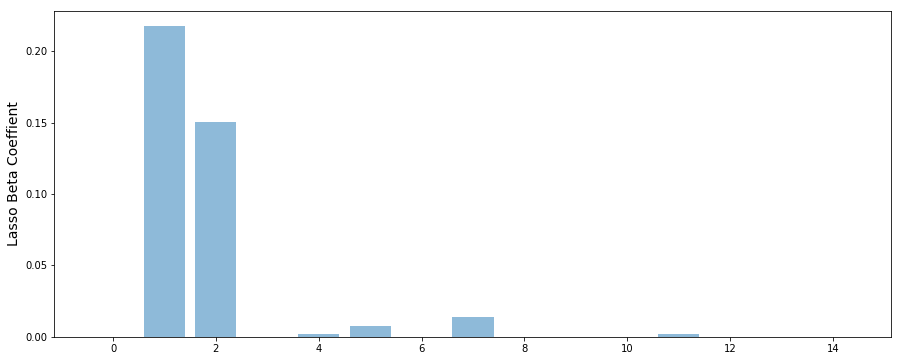

(21,) (21,)


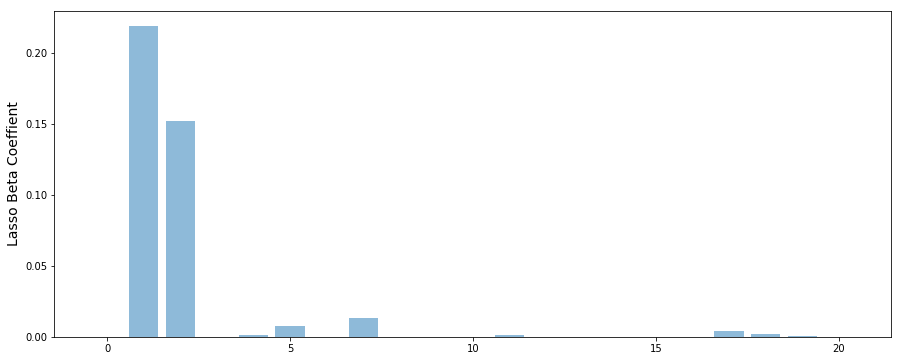

(28,) (28,)


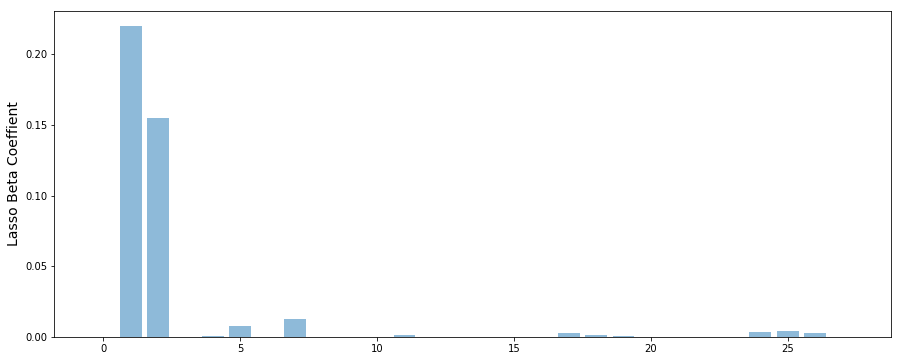

(36,) (36,)


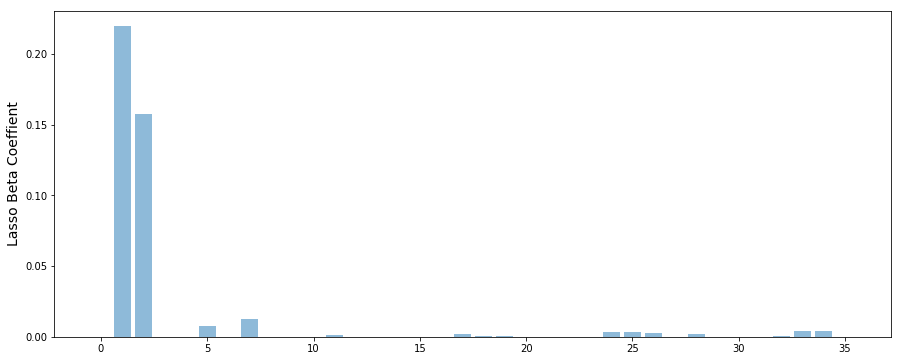

(45,) (45,)


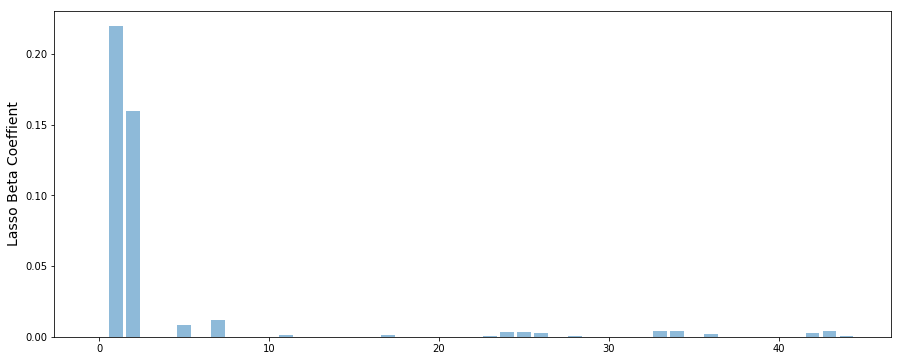

(55,) (55,)


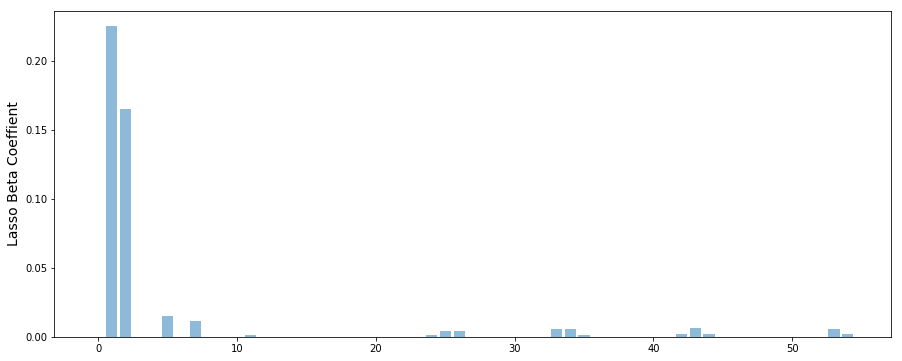

(66,) (66,)


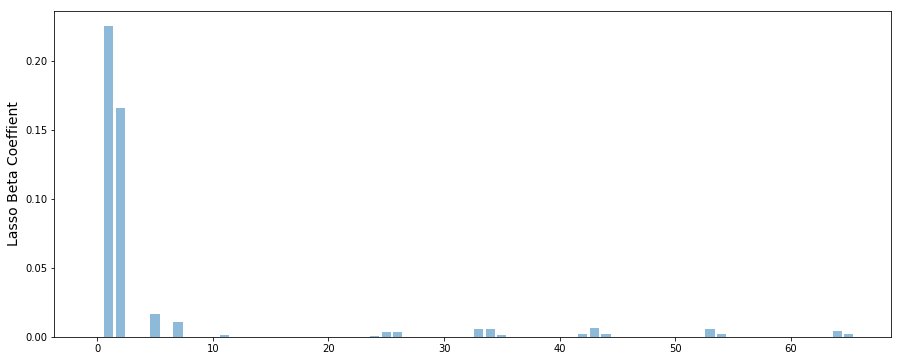

(78,) (78,)


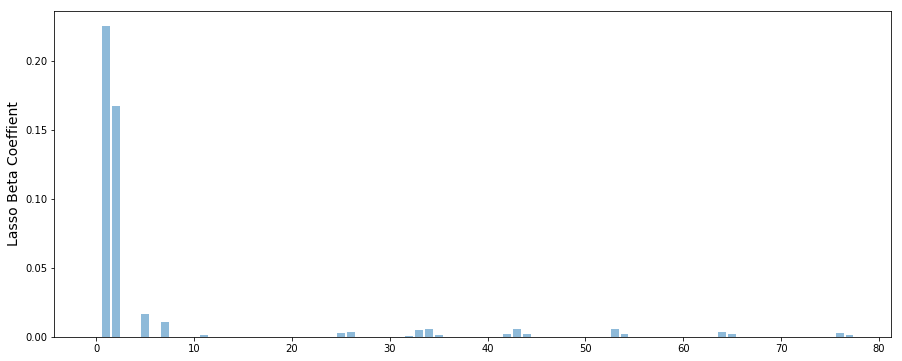

(91,) (91,)


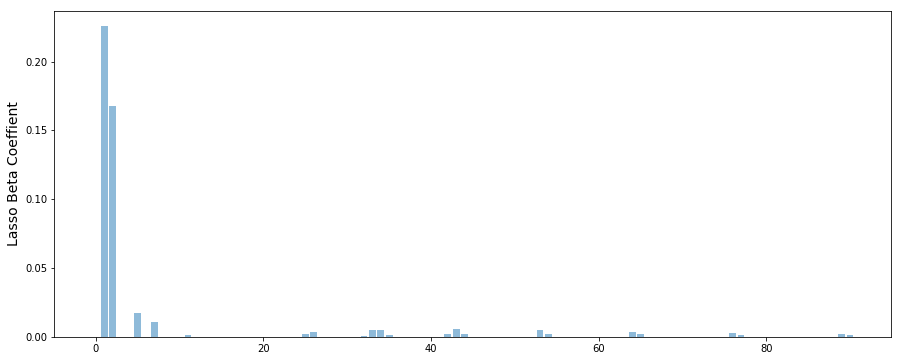

(105,) (105,)


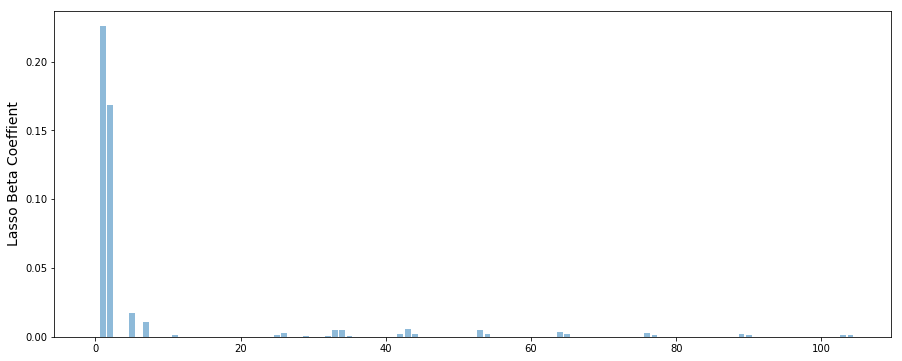

In [146]:
N = 30
x, y = np.random.uniform(0,1,size=(2,N))
x_,y_ = np.meshgrid(x,y)
z = fn.FrankeFunction(x_, y_,0.5)
z = np.ravel(z)

# Array of polynomial degrees
n=np.arange(15)[1:]
X = fn.create_X(x_,y_,n[-1])

# Splitting into testing and training
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Creating arrays for train and test error
TrainError = np.zeros(n.shape)
TestError = np.zeros(n.shape)

# Scaling the train and test set
X_train, X_test = fn.Scaling(X_train, X_test)

for i in range(len(n)):

    # How many columns of the design matrix allowed.
    q = int((i+1)*(i+2)/2)
    X_trainD = X_train[:,:q]
    X_testD = X_test[:,:q]


    clf = linear_model.Lasso(alpha=0.01, fit_intercept=True, tol=0.1, max_iter=10000)
    clf.fit(X_trainD, z_train)
    LASSObeta = clf.coef_
    z_tilde = X_trainD @ LASSObeta
    z_predict = X_testD @ LASSObeta
   

    
    fig, ax = plt.subplots(figsize=(15,6))

    x_pos = np.arange((len(LASSObeta)))
    print(x_pos.shape, LASSObeta.shape)
    plt.figure()
    ax.bar(x_pos, np.abs(LASSObeta), alpha=0.5,capsize=10)
    ax.set_ylabel('Lasso Beta Coeffient', fontsize=14)
    plt.show()
    
    TrainError[i] = fn.MSE(z_train, z_tilde)
    TestError[i] = fn.MSE(z_test, z_predict)



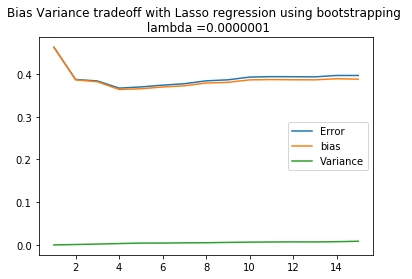

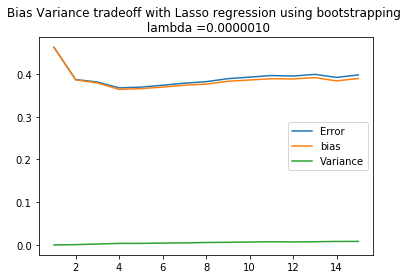

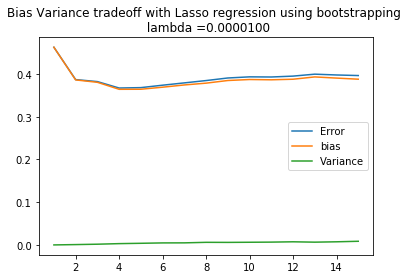

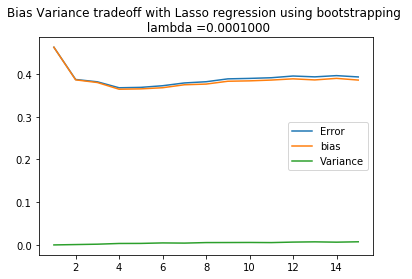

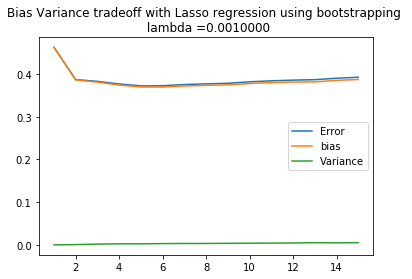

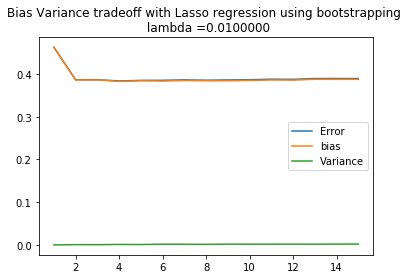

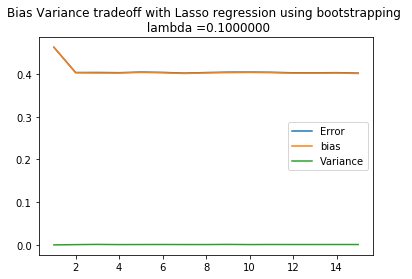

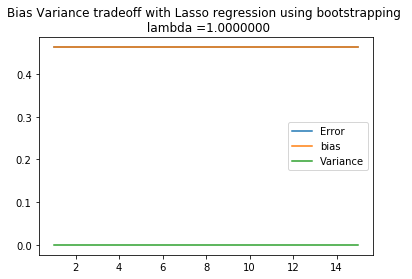

In [131]:
startpoint = 0
endpoint = 15
lamb_index = 2
for k in range(len(lamb)):
    plt.plot(n[startpoint:endpoint], error[k,startpoint:endpoint], label='Error')
    plt.plot(n[startpoint:endpoint], bias[k,startpoint:endpoint], label='bias')
    plt.plot(n[startpoint:endpoint], variance[k,startpoint:endpoint], label='Variance')
    plt.title("Bias Variance tradeoff with Lasso regression using bootstrapping \n lambda =%.07f" % lamb[k])
    plt.legend()
    #plt.ylim(-0.01, 0.2)
    plt.show()

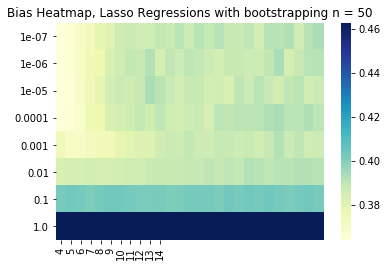

In [147]:
import seaborn as sns
lambtick = np.ndarray.tolist(lamb)
ntick = np.ndarray.tolist(n)


ax = sns.heatmap(bias[:,3:], cmap="YlGnBu", yticklabels = lambtick, xticklabels = ntick[3:])
plt.title("Bias Heatmap, Lasso Regressions with bootstrapping n = 50")

plt.show()

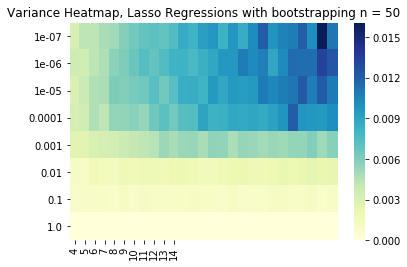

In [148]:
ax = sns.heatmap(variance[:,3:], cmap="YlGnBu", yticklabels = lambtick, xticklabels = ntick[3:])
plt.title("Variance Heatmap, Lasso Regressions with bootstrapping n = 50")

plt.show()

## f) Introducing real data and preparing the data analysis

### Get data from dta folder of project 1. 

In [ ]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# Load the terrain
terrain1 = imread("SRTM_data_Norway_1.tif")
# Show the terrain
plt.figure()
plt.title("Terrain over Norway 1")
plt.imshow(terrain1, cmap="gray")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


## g) OLS, Ridge and Lasso regression with resampling

### Apply all three methods on the terrain data, with the same polynomial approximation and cross-validation as resampling technique to evaluate which model fits the data best.
### "Present a critical evaluation of your results and disucss the applicability of these regreesion methods to the type of the data presented here (either the terrain data we propose or other data sets)."